# NLP Methods on Music Reviews
This notebook covers ingesting and preprocessing the text of music reviews, retrieved from the Kaggle dataset [song reviews](https://www.kaggle.com/nolanbconaway/pitchfork-data)

In [12]:
import pandas as pd
import numpy as np
import sqlite3
import string, re
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer



[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ElyasAmin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ElyasAmin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ElyasAmin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/ElyasAmin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Import Data
The data is stored as a series of tables within a sqlite database. The following cells extract each table and convert them to Pandas dataframes.

### Connect to the Database

In [14]:
connection = sqlite3.connect('database.sqlite')
cursor = connection.cursor()

### Reviews Table

In [15]:
query = "select * from reviews;"
cursor.execute(query)
df_reviews = pd.DataFrame(cursor.fetchall(), columns=["id",'track', 'artist', 'url','score',
    'best_new_music', 'author', 'author_type','date','weekday', 'day', 'month', 'year'])
df_reviews.head()

,id,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


In [16]:
len(df_reviews)

18393

### Content Table

In [17]:
query = "select * from content;"
cursor.execute(query)
df_content = pd.DataFrame(cursor.fetchall(), columns=["id",'review'])
df_content.head()

,id,review
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


### Genres Table

In [48]:
query = "select * from genres;"
cursor.execute(query)
df_genres = pd.DataFrame(cursor.fetchall(), columns=["id",'genre'])
df_genres.head()
df_genres['genre'].value_counts()
de

          id         genre
0      22703    electronic
1      22721         metal
2      22659          rock
3      22661          rock
4      22725    electronic
...      ...           ...
22675   5376          rock
22676   2413          rock
22677   2413         metal
22678   2413  experimental
22679   3723          None

[22680 rows x 2 columns]


### Music Label Table

In [20]:
query = "select * from labels;"
cursor.execute(query)
df_labels = pd.DataFrame(cursor.fetchall(), columns=["id", "music_label"])
df_labels.head()

,id,music_label
0,22703,virgin
1,22721,hathenter
2,22659,static shock
3,22659,fashionable idiots
4,22661,kill rock stars


## Merge Dataframes

In [21]:
df = df_content.merge(df_reviews, on='id')
# df = df.merge(df_labels, on='id')
df.drop_duplicates(inplace=True)
df.head(5)

,id,review,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,"Eight years, five albums, and two EPs in, the ...",prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,Kleenex began with a crash. It transpired one ...,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,It is impossible to consider a given release b...,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


In [22]:
len(df)

18389

In [47]:
# df.to_parquet("datasets/reviews.parquet")

# EDA
We perform light exploratory data analysis to understand the contents of the dataset

In [23]:
# descriptive statistics of score column

df.score.describe()

count    18389.000000
mean         7.005715
std          1.293758
min          0.000000
25%          6.400000
50%          7.200000
75%          7.800000
max         10.000000
Name: score, dtype: float64

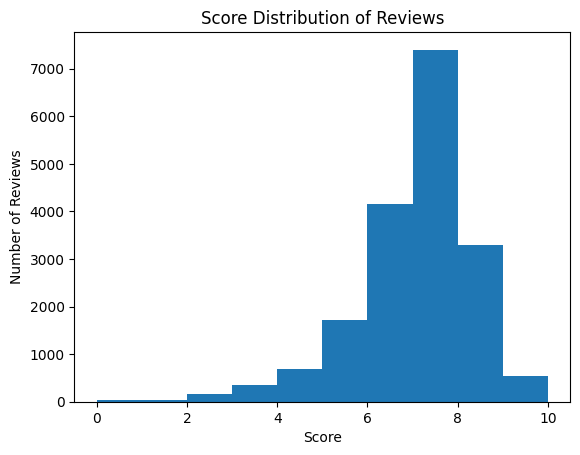

In [30]:
# distribution of scores

plt.hist(df.score)
plt.title("Score Distribution of Reviews")
plt.xlabel("Score")
plt.ylabel("Number of Reviews")
plt.savefig("/Users/ElyasAmin/Desktop/Project/Score Distribution of Reviews.png")

TypeError: 'value' must be an instance of str or bytes, not a None

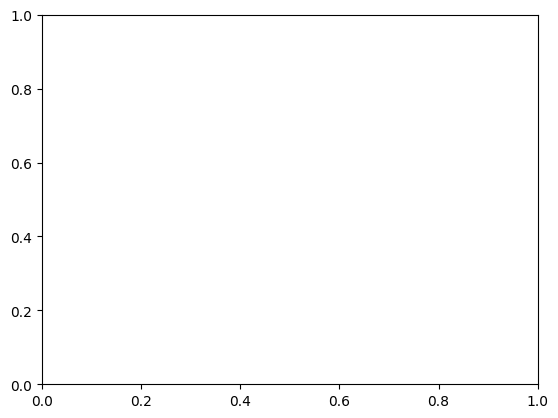

In [47]:
# plt.hist(df_genres.genre)
# plt.title("Score Distribution of Reviews")
# plt.xlabel("Score")
# plt.ylabel("Number of Reviews")
# plt.savefig("/Users/ElyasAmin/Desktop/Project/Score Distribution of Reviews.png")

In [49]:
# Average length of reviews

review_lengths = df.review.apply(lambda x: len(x.split(' ')))
print("Average length of reviews:",review_lengths.mean())
print("Number of words from all reviews:",review_lengths.sum())

Average length of reviews: 703.0016857904182
Number of words from all reviews: 12927498


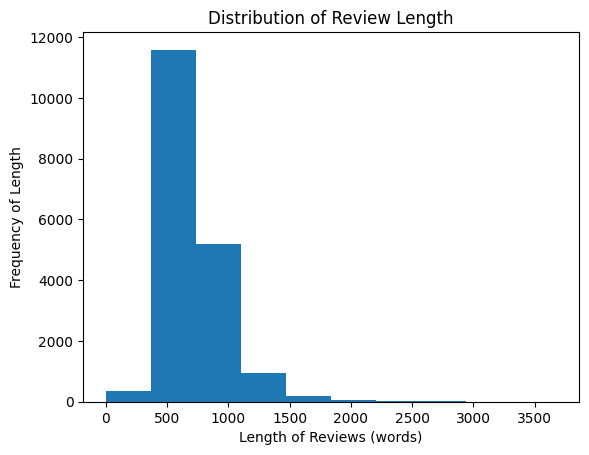

In [50]:
plt.hist(review_lengths)
plt.title("Distribution of Review Length")
plt.xlabel("Length of Reviews (words)")
plt.ylabel("Frequency of Length")
plt.savefig("/Users/ElyasAmin/Desktop/Project/Distribution of Review Length.png")

# Data Pre-processing
The following cells perform text preprocessing steps


In [51]:
def tokenize(texts):
    """Tokenize and convert to lower case"""
    tokenized = []
    for text in texts:
        tokenized.append(nltk.word_tokenize(text.lower()))
    return(tokenized)

In [52]:
def stop_words(tokenized_texts):
    """Remove stopwords and punctuation from each review"""
    stopped = []
    eng_stopwords = stopwords.words('english')
    eng_stopwords += list(string.punctuation)
    eng_stopwords += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘']
    for token_list in tokenized_texts:
        stopwords_removed = [token for token in token_list if token not in eng_stopwords]
        stopped.append(stopwords_removed)

    return stopped

In [53]:
def lemmatize(tokenized_texts):
    lemmatizer = WordNetLemmatizer()
    lemmatized = []
    for token_list in tokenized_texts:
        lemmatized.append([lemmatizer.lemmatize(token) for token in token_list])
    return lemmatized

### Implement Tokenization, Stop Word Removal, and Lemmatization

In [54]:
tokenized = tokenize(df.review)
no_stop = stop_words(tokenized)
lemmed = lemmatize(no_stop)
len(lemmed)

18389

In [55]:
# join tokens back together to save as parquet file
processed = []
for token_list in lemmed:
    processed.append(' '.join(token_list))
len(processed)

18389

In [75]:
df["preprocessed_review"] = processed
# df.to_parquet("datasets/processed_reviews.parquet")
df.head()


,id,review,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year,preprocessed_review,elyas,Sentiment List (Pos/Neg/Neu)
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,trip-hop eventually became 90 punchline music-...,10.3,10.3
1,22721,"Eight years, five albums, and two EPs in, the ...",prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,eight year five album two eps new york-based o...,8.9,8.9
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,minneapolis uranium club seem revel aggressive...,8.3,8.3
3,22661,Kleenex began with a crash. It transpired one ...,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,kleenex began crash transpired one night long ...,10.0,10.0
4,22725,It is impossible to consider a given release b...,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,impossible consider given release footwork art...,9.1,9.1


### Inspect first 100 characters of sample review, comparing raw review vs pre-processed

In [76]:
# Preprocessed
df.preprocessed_review[0][:100]

'trip-hop eventually became 90 punchline music-press shorthand overhyped hotel lounge music. today mu'

In [77]:
# Original
df.review[0][:100]

'“Trip-hop” eventually became a ’90s punchline, a music-press shorthand for “overhyped hotel lounge m'

In [78]:
preprocessed_review_lengths = df.preprocessed_review.apply(lambda x: len(x.split(' ')))
print("Average token length of reviews:",preprocessed_review_lengths.mean())
print("Number of tokens from all reviews:",preprocessed_review_lengths.sum())

Average token length of reviews: 394.39061395399426
Number of tokens from all reviews: 7252449


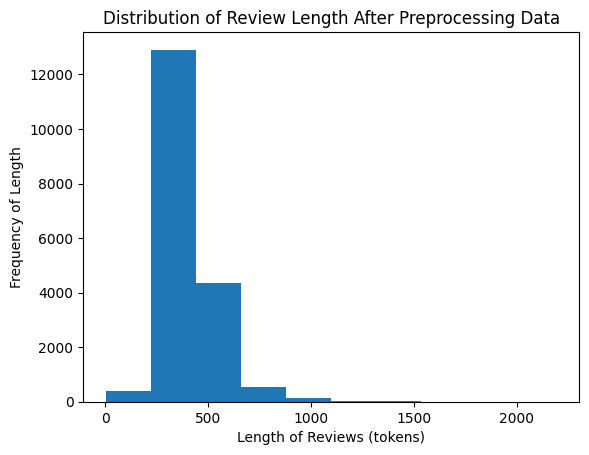

In [79]:
plt.hist(preprocessed_review_lengths)
plt.title("Distribution of Review Length After Preprocessing Data")
plt.xlabel("Length of Reviews (tokens)")
plt.ylabel("Frequency of Length")
plt.savefig("/Users/ElyasAmin/Desktop/Project/Distribution of Review Length(tokens).png")

## Baseline Implementation

#### Importing Lexicons/Counting Sentiments

In [82]:
from textblob import TextBlob

In [92]:
#Function to make list of each sentiment type 
def sentiment_counter(token_list):
    pos_word_list = []
    neg_word_list = []
    neu_word_list = []

    for word in token_list:
        testimonial = TextBlob(word)
        if testimonial.sentiment.polarity >= 0.5:
            pos_word_list.append(word)
        elif testimonial.sentiment.polarity <= -0.5:
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)
    return pos_word_list, neg_word_list, neu_word_list
        

In [95]:
#Adding the sentiments to the df
df["Sentiment List (Pos/Neg/Neu)"] = df['preprocessed_review'].apply(lambda x:sentiment_counter(x.split()))

df


# test = sentiment_counter(df.loc[0, "preprocessed_review"].split('.'))
# print(test)


,id,review,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year,preprocessed_review,elyas,Sentiment List (Pos/Neg/Neu)
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,trip-hop eventually became 90 punchline music-...,10.3,"([best, famous, love, beautiful, top, sure, cr..."
1,22721,"Eight years, five albums, and two EPs in, the ...",prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,eight year five album two eps new york-based o...,8.9,"([great, best, spontaneously, good], [grim, ha..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,minneapolis uranium club seem revel aggressive...,8.3,"([many, love, talented, perfect], [vaguely, ca..."
3,22661,Kleenex began with a crash. It transpired one ...,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,kleenex began crash transpired one night long ...,10.0,"([nice, delighted, ok, greatest, perfect, amus..."
4,22725,It is impossible to consider a given release b...,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,impossible consider given release footwork art...,9.1,"([remarkable, best, warm, perfect, perfect, ab..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18396,1535,The marketing guys of yer average modern megac...,let us replay!,coldcut,http://pitchfork.com/reviews/albums/1535-let-u...,8.9,0,james p. wisdom,None,1999-01-26,1,26,1,1999,marketing guy yer average modern megaconglomer...,9.9,"([love, interesting, good, good, pleased], [va..."
18397,1341,"Well, it's been two weeks now, and I guess it'...",1999,cassius,http://pitchfork.com/reviews/albums/1341-1999/,4.8,0,james p. wisdom,None,1999-01-26,1,26,1,1999,well 's two week guess 's time tell guy someth...,5.8,"([plausible, sure, sure, sure, beloved, better..."
18398,5376,"Out of Tune is a Steve Martin album. Yes, I'l...",out of tune,mojave 3,http://pitchfork.com/reviews/albums/5376-out-o...,6.3,0,jason josephes,contributor,1999-01-12,1,12,1,1999,tune steve martin album yes 'll explain upon t...,7.3,"([notably, catching, sure, good, good, happy, ..."
18399,2413,"Well, kids, I just went back and re-read my re...","singles breaking up, vol. 1",don caballero,http://pitchfork.com/reviews/albums/2413-singl...,7.2,0,james p. wisdom,None,1999-01-12,1,12,1,1999,well kid went back re-read review guy last alb...,8.2,"([love, sure, sure, love, perfect, enjoying], ..."


In [103]:
df.to_csv("/Users/ElyasAmin/Desktop/Project/Preprocessed Data with Sentiment List.csv", index = False)

In [105]:
#make columns of counts of each sentiment
df["Positive Sentiment Count"] = df['Sentiment List (Pos/Neg/Neu)'].apply(lambda x:len(x[0]))
df["Negative Sentiment Count"] = df['Sentiment List (Pos/Neg/Neu)'].apply(lambda x:len(x[1]))
df["Neutral Sentiment Count"] = df['Sentiment List (Pos/Neg/Neu)'].apply(lambda x:len(x[2]))
df

,id,review,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year,preprocessed_review,Sentiment List (Pos/Neg/Neu),Positive Sentiment Count,Negative Sentiment Count,Neutral Sentiment Count
0,22703,"“Trip-hop” eventually became a ’90s punchline,...",mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017,trip-hop eventually became 90 punchline music-...,"([best, famous, love, beautiful, top, sure, cr...",11,3,846
1,22721,"Eight years, five albums, and two EPs in, the ...",prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017,eight year five album two eps new york-based o...,"([great, best, spontaneously, good], [grim, ha...",4,3,269
2,22659,Minneapolis’ Uranium Club seem to revel in bei...,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017,minneapolis uranium club seem revel aggressive...,"([many, love, talented, perfect], [vaguely, ca...",4,3,319
3,22661,Kleenex began with a crash. It transpired one ...,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017,kleenex began crash transpired one night long ...,"([nice, delighted, ok, greatest, perfect, amus...",16,2,727
4,22725,It is impossible to consider a given release b...,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017,impossible consider given release footwork art...,"([remarkable, best, warm, perfect, perfect, ab...",11,1,297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18396,1535,The marketing guys of yer average modern megac...,let us replay!,coldcut,http://pitchfork.com/reviews/albums/1535-let-u...,8.9,0,james p. wisdom,None,1999-01-26,1,26,1,1999,marketing guy yer average modern megaconglomer...,"([love, interesting, good, good, pleased], [va...",5,2,273
18397,1341,"Well, it's been two weeks now, and I guess it'...",1999,cassius,http://pitchfork.com/reviews/albums/1341-1999/,4.8,0,james p. wisdom,None,1999-01-26,1,26,1,1999,well 's two week guess 's time tell guy someth...,"([plausible, sure, sure, sure, beloved, better...",6,2,126
18398,5376,"Out of Tune is a Steve Martin album. Yes, I'l...",out of tune,mojave 3,http://pitchfork.com/reviews/albums/5376-out-o...,6.3,0,jason josephes,contributor,1999-01-12,1,12,1,1999,tune steve martin album yes 'll explain upon t...,"([notably, catching, sure, good, good, happy, ...",9,9,439
18399,2413,"Well, kids, I just went back and re-read my re...","singles breaking up, vol. 1",don caballero,http://pitchfork.com/reviews/albums/2413-singl...,7.2,0,james p. wisdom,None,1999-01-12,1,12,1,1999,well kid went back re-read review guy last alb...,"([love, sure, sure, love, perfect, enjoying], ...",6,2,235


In [106]:
df.to_csv("/Users/ElyasAmin/Desktop/Project/Preprocessed Data with Sentiment List.csv", index = False)

In [107]:
#Making Labels
df['label'] = df['score'].apply(lambda sc: 1 if sc>=7 else 0)

#### Naive Bayes Model Application

In [150]:
df2 = df[["score","label", "Positive Sentiment Count", "Negative Sentiment Count", "Neutral Sentiment Count"]]
df2

,score,label,Positive Sentiment Count,Negative Sentiment Count,Neutral Sentiment Count
0,9.3,1,11,3,846
1,7.9,1,4,3,269
2,7.3,1,4,3,319
3,9.0,1,16,2,727
4,8.1,1,11,1,297
...,...,...,...,...,...
18396,8.9,1,5,2,273
18397,4.8,0,6,2,126
18398,6.3,0,9,9,439
18399,7.2,1,6,2,235


In [151]:
train = df2.drop(['label','score'],axis = 1)
labels = df2['label']

In [153]:
from sklearn.preprocessing import StandardScaler

In [154]:
#Normaling the data

scaler = StandardScaler()

scaler.fit(train)
sc_train = scaler.transform(train)


In [155]:
sc_train



array([[ 0.19694395, -0.29105665,  3.51217315],
       [-1.12598127, -0.29105665, -0.84172528],
       [-1.12598127, -0.29105665, -0.46443772],
       ...,
       [-0.18103468,  1.68795637,  0.44105242],
       [-0.74800263, -0.62089215, -1.09828082],
       [-0.93699195,  0.36861436, -1.56611739]])

In [171]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error


In [172]:
#Split data 80/20
#x_train,x_test,y_train,y_test = train_test_split(sc_train,labels,test_size = 0.2)

In [176]:
#Creating Logistic Regression Model

model = LogisticRegression().fit(sc_train,labels)

In [177]:
#Predicting the probability of the entire dataset
preds = model.predict_proba(sc_train)

In [178]:
preds

array([[0.05227282, 0.94772718],
       [0.45534106, 0.54465894],
       [0.39432112, 0.60567888],
       ...,
       [0.45666805, 0.54333195],
       [0.47903022, 0.52096978],
       [0.63882854, 0.36117146]])

In [179]:
#taking only the positive class and multiplying it by 10
ns = preds[:,1]
ns = ns*10

In [181]:
#Rounding it to first decimal point
rs = []
for val in ns:
    rs.append(round(val,1))
# print(rs)

In [182]:
#Mean sqaured error
mean_squared_error(df2['score'],rs)

2.880778182609169